# Spike-LFP Coupling

Neural oscillations reflect the spike timing of neurons. Identifying how neurons fire in relation to oscillations can help uncover which neurons participate in an oscillation, and and to what degree. This notebook will demonstrate how to quantify how the spike timing of neurons relates to underlying oscillations. Specifically, this notebook shows how to:
1. Filter data into a frequency band
2. Extract phase information
3. Visualize spike-lfp coupling
4. Quantify spike-lfp coupling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
import math
import itertools
import random
import time

Let's start by simulating an oscillation, and a neuron that tends to fire at the trough of the oscillation. We'll plot the spikes as vertical lines over the lfp.

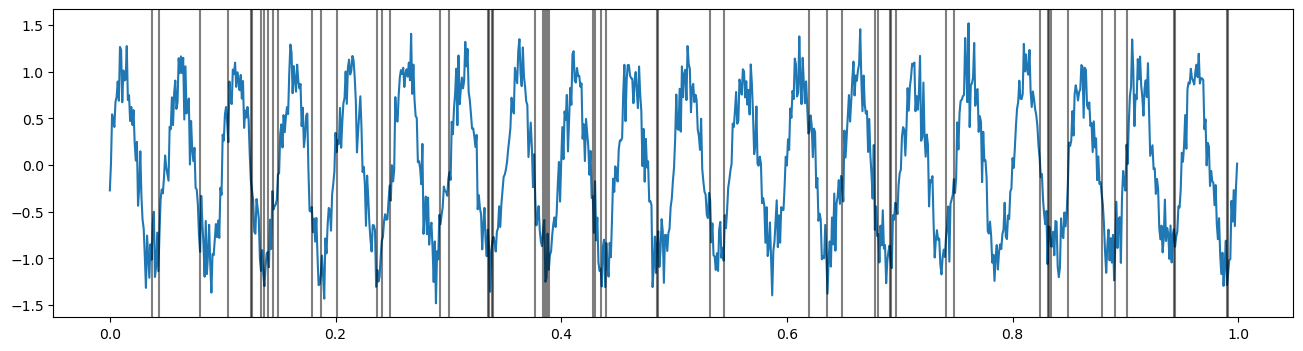

In [2]:
#Simulate LFP
fs = 1000
times = np.arange(0, 1, 1/fs)
freq = 20
lfp = np.sin(2 * np.pi * times[:] * freq)
noise = np.random.normal(0, .2, size=times.shape)
lfp += noise
plt.figure(figsize=(16, 4))
plt.plot(times, lfp)
#Simulate neuron
spike_times = []
lfp_min0 = lfp-np.min(lfp)+.001
for i in range(0,len(times)):
    probability = (2 - lfp_min0[i])/10
    if probability > 0:
        sample = np.random.choice([0,1],p=[1-probability, probability])
        if sample==1:
            spike_times.append(times[i])
for spike in spike_times:
    plt.axvline(spike, color='black', alpha=.5)

We'll want to look at how the neuron fires with respect to some particular oscillation, or frequency band. To do so, we need to filter the lfp signal into a range of interest. Let's start by filtering in the beta (12-32Hz) band.

## Filtering and Phase

Filtering is used to emphasize or demphasize activity in particular frequencies in time-series. Common applications of filters to neural electrophysiological data are to remove 60Hz line noise, remove low frequency activity for spike detection / remove high frequency activity for LFP analyses, and to isolate specific oscillations. 


There are many commonly used filter designs, with customizable parameters. The goal of each filter is to maximize the attennuation of unwanted frequencies, which can be best achieved using filters with a narrow transition band in frequency space. However, these "sharp" filters produce stronger signal distortions and ringing artifacts. Therefore, choices in filter design often come down to this trade-off [[1]](#references). Additionally, higher filter orders effectively decrease the time resolution while increasing the frequency resolution. Here, we'll use a butterworth filter, which is maximally uniform in how it affects the magnitude of activity in the filtered frequency range. Additionally, we'll use an order of 4. Feel free to try other filter designs (cheby2, bessel) or orders to see their affects.

Filters are often applied through convolution over the signal. This can distort phase estimation, as convolving in a particular direction will result in a phase shift. To eliminate this shift, filters can be convolved once forwards and then backwards, which we will do with scipy's [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) function. 

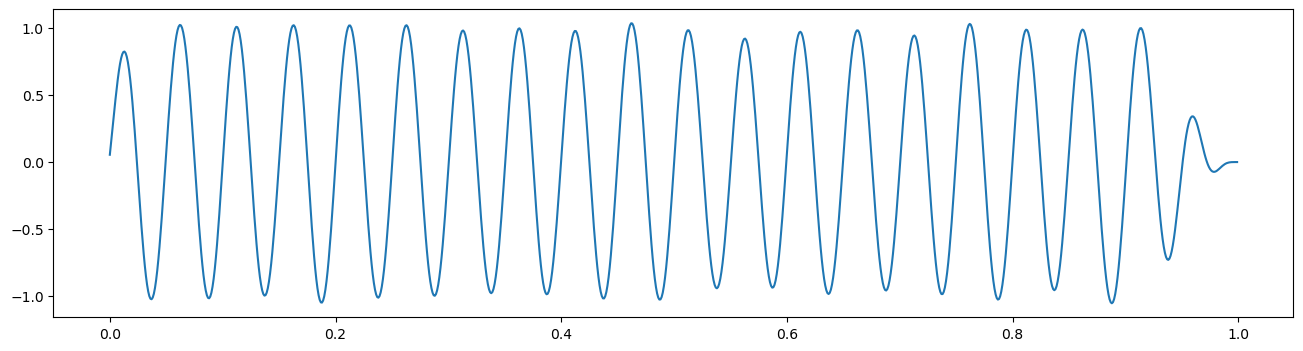

In [3]:
order=4
freq_band = [12, 32]
b, a = butter(order, freq_band, fs=fs, btype='band')
filt_data = filtfilt(b, a, lfp, padtype=None)
plt.figure(figsize=(16,4))
plt.plot(times, filt_data)

As you can see, we've removed a lot of the noise and cleanly uncovered the underlying oscillation.

Now we have extracted our oscillation, but we want to see whether the neuron's spike timing is affected by this oscillation. One useful way to investigate this question is to look at whether the neuron tends to fire at some particular phase of the oscillation more than others. We therefore start by extracting the phase information for this oscillation. To get this, you use the hilbert transform to produce the analytic signal. This analytic signal is complex valued and contains both the instantaneous amplitude and phase information for our signal. The phase can be easily extracted by calling np.angle() function on the analytic signal.

Text(0, 0.5, 'Phase (degrees)')

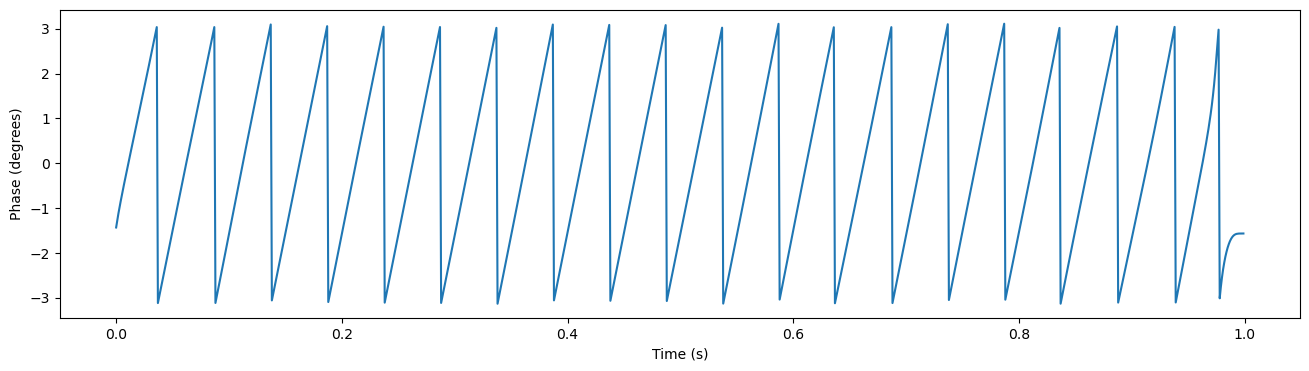

In [4]:
analytic_signal = hilbert(filt_data)
phase = np.angle(analytic_signal, deg=False)
plt.figure(figsize=(16,4))
plt.plot(times, phase)
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

## Quantify Spike LFP-Coupling

Now let's try to see how the spike times of the neuron align to this beta oscillation. A good way to start is to create a histogram of these spike times by binning over their oscillation phase. 

First, let's collect the phases when the neuron spiked.

In [5]:
spike_phases = []
for spike_time in spike_times:
    spike_phases.append(phase[int(round(spike_time*fs))])

To create the histogram, we then bin these spike phases using numpy's digitize function, and then count up how many phases we have in each phase bin. 

[ 0.  6.  8.  3.  3.  8.  0.  1.  0.  0.  0.  0.  1.  0.  3.  5.  5.  5.
 10.]


<BarContainer object of 19 artists>

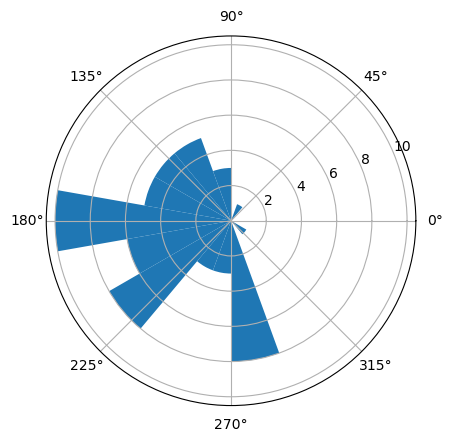

In [6]:
n_bins = 18
phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
spike_phase_hist = np.zeros(n_bins+1)
for bin in range(0, n_bins + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(phase_bins, spike_phase_hist, width=phase_bins[1] - phase_bins[0], bottom=0.0)

We can now see spikes are more likely to fire around 180 degrees phase, or the trough, of the oscillation. Let's try to quantify the extent of this spike-phase coupling. To do so, I'll use mean vector length, and pairwise phase coherence. 

**Mean Vector length**

A common way to measure spike phase locking is to take the length of the mean vector of the spike-phase distribution [[2]](#references). If spikes are uniformally distributed with respect to phase, the mean of this distribution will be a point close to the center of the circle, and its radius will be close to 0. On the other hand, if spikes are clustered around some particular phase, the mean vector will point towards that phase and thus will have a radius closer to 1.

To calculate the mean vector length (mvl) of our distribution, we first need to map the spike phase distribution into polar coordinates and then take their mean. The mvl is then the distance of this point from (0,0).  

In [7]:
def MVL(spike_phases):
    a_cos = map(lambda x: math.cos(x), spike_phases)
    a_sin = map(lambda x: math.sin(x), spike_phases)
    a_cos, a_sin = np.fromiter(a_cos, dtype=float), np.fromiter(a_sin, dtype=float) 
    uv_x = sum(a_cos)/len(a_cos)
    uv_y = sum(a_sin)/len(a_sin)
    uv_radius = np.sqrt((uv_x*uv_x) + (uv_y*uv_y))
    p_value = np.round(np.exp(-1 * len(spike_phases) * (uv_radius ** 2)), 6)
    return uv_radius, p_value

vec_length, pval = MVL(spike_phases)
print('Mean vector length: '+ str(round(vec_length,3))+', p value: '+str(pval))

Mean vector length: 0.592, p value: 0.0


We get a p value of 0, indicating phase locking is highly significant. 
However, this measure is highly dependent on the number of spikes in our sample [[3]](#references), as small samples will lead to a mean centered away from (0,0) even if spike phases are uniformally distributed.

One way to get around this is to repeatedly estimate the mvl on a surrogate spike phase distribution with the same number of samples as our actual sample, and estimate the difference between our real result and these surrogate estimates.

Text(0.6, 20, 'Z-score: 7.69154573726944')

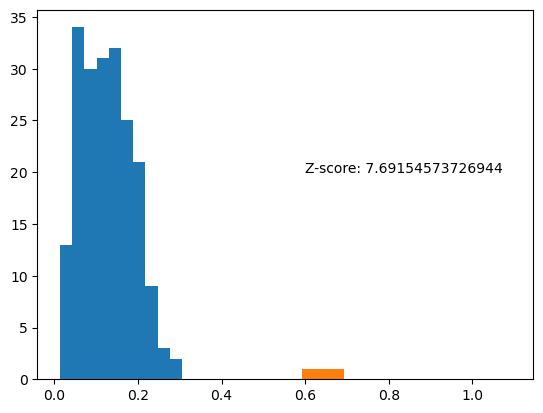

In [8]:
n_surrogates = 200
sample_size = len(spike_phases)
mvl_surrogates = [None] * n_surrogates
for surr in range(0, n_surrogates):
    spike_phases_surr = random.choices(phase, k=sample_size) #see note
    mvl_surrogates[surr], p = MVL(spike_phases_surr)

z_score = (vec_length - np.mean(mvl_surrogates)) / np.std(mvl_surrogates)
plt.hist(mvl_surrogates)
plt.hist(vec_length)
plt.text(.6, 20, 'Z-score: '+ str(z_score))

The real mvl is clearly significantly higher than these surrogates, indicating spike-phase coupling is significant.

*Note*: We could have randomly sampled from any number between -np.pi and np.pi, but instead I sampled from the actual observed phase values. This controls for a potential bias of spike-phase locking estimation, where not all phase values are observed in the oscillation itself. This occurs in smaller samples, where the length of the sample is less than a full cycle. If not all phases are observed, than the spike-phase distribution will be artificially non-uniform, and significant when compared to a surrogate distribution containing all possible phase values. 

 **Pairwise Phase Consistency**
 
 Alternatively, another measure of spike-phase locking, pairwise phase consistency (ppc), is unbiased by the number of samples [[3]](#references). The measure computes the cosine of the angular distance between each pair of phases, resulting in an output of 1 for pairs of the same phase and -1 for antiphase pairs. After averaging across pairs, the measure will approach 0 for a uniform phase distribution and 1 for a perfectly aligned phase distribution.

In [9]:
def PPC(spike_phases):
    sp_complex = map(lambda x: [math.cos(x), math.sin(x)], spike_phases)
    all_com = list(itertools.combinations(sp_complex , 2))
    dp_array = np.empty(int(len(spike_phases) * (len(spike_phases) - 1) / 2))
    for d, combination in enumerate(all_com):
        dp = np.dot(combination[0], combination[1])
        dp_array[d] = dp
    dp_sum = np.sum(dp_array)
    ppc = dp_sum / len(dp_array)
    return ppc
    
ppc_val = PPC(spike_phases)
print('PPC: ' + str(ppc_val))

PPC: 0.33952146217224755


The only disadvantage of using ppc over mvl is ppc, by computing the dot product between each possible phase pair, takes longer. Let's illustrate that by measuring the time each function takes for a sample with 1000 phases.

In [10]:
spike_phases = [np.pi for x in range(0,1000)]
start = time.process_time()
MVL(spike_phases)
stop = time.process_time()
print('Mean Vector Length process time: ' + str(stop-start))
start = time.process_time()
PPC(spike_phases)
stop = time.process_time()
print('Pairwise Phase Consistency process time: ' + str(stop-start))

Mean Vector Length process time: 0.0


Pairwise Phase Consistency process time: 1.453125


Clearly the PPC take significantly longer to compute. Though this time is still tolerable, or if you were to run ppc on many surrogate distributions (to capture the bias of the measure due to an incomplete phase distribution, for example), this time can add up. Therefore, when comparing with surrogate data, the mvl is more often used.

## References
1. Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data – a practical approach. Journal of Neuroscience Methods, 250, 34–46. https://doi.org/10.1016/J.JNEUMETH.2014.08.002
2. Canolty RT, Edwards E, Dalal SS, Soltani M, Nagarajan SS, Kirsch HE, et al. High Gamma Power Is Phase-Locked to Theta Oscillations in Human Neocortex. Science (80- ) [Internet]. 2006 Sep 15 [cited 2019 Aug 7];313(5793):1626–8. Available from: http://www.sciencemag.org/cgi/doi/10.1126/science.1128115
3. Vinck M, van Wingerden M, Womelsdorf T, Fries P, Pennartz CMA. The pairwise phase consistency: A bias-free measure of rhythmic neuronal synchronization. Neuroimage. 2010 May 15;51(1):112–22. 